In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.inspection import permutation_importance

# Optional (advanced imbalance)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# phase 1

In [2]:
df=pd.read_csv("C:\\Users\\hp\\Downloads\\cr_loan.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [3]:
# Check the structure of the data
print(df.dtypes)

# Check the first five rows of the data
print(df.head())

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D

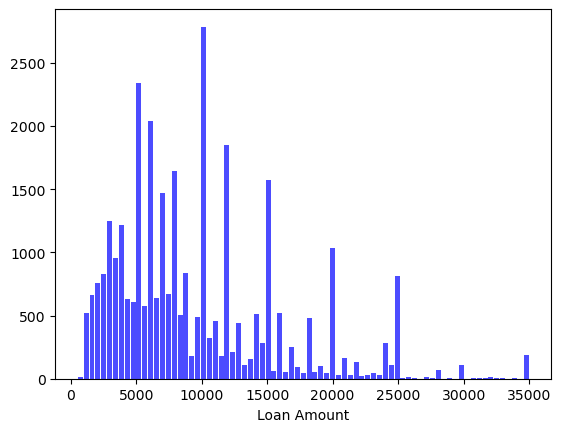

In [4]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=df['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

There are 32 000 rows of data so the scatter plot may take a little while to plot.


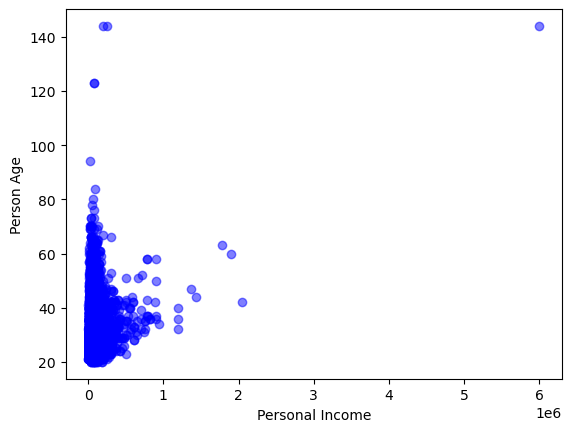

In [5]:
print("There are 32 000 rows of data so the scatter plot may take a little while to plot.")

# Plot a scatter plot of income against age
plt.scatter(df['person_income'], df['person_age'], c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Person Age')
plt.show()


In [6]:
# Create a cross table of the loan intent and loan status
print(pd.crosstab(df['loan_intent'], df['loan_status'], margins=True))


loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


In [7]:
# Create a cross table of home ownership, loan status, and grade
print(pd.crosstab(df['person_home_ownership'], [df['loan_status'], df['loan_grade']]))


loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27  


In [8]:
# Create a cross table of home ownership, loan status, and average percent income
print(pd.crosstab(df['person_home_ownership'], df['loan_status'],
                  values=df['loan_percent_income'], aggfunc='mean'))


loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


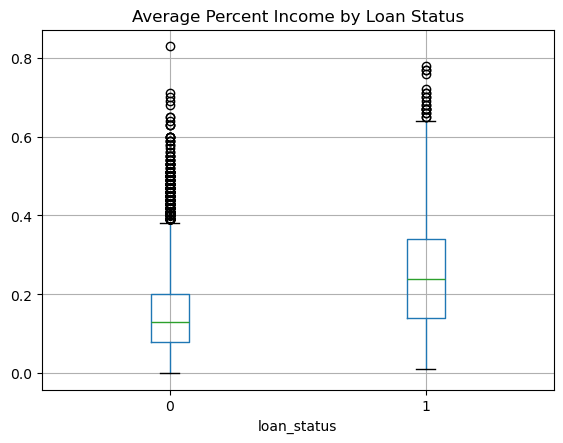

In [9]:
# Create a box plot of percentage income by loan status
df.boxplot(column=['loan_percent_income'], by='loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()



In [10]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(df['loan_status'], df['person_home_ownership'],
                  values=df['person_emp_length'], aggfunc='max'))


person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


In [11]:
# Create an array of indices where employment length is greater than 60
indices = df[df['person_emp_length'] > 60].index
indices


Index([0, 210], dtype='int64')

In [12]:
# Drop the records from the data based on the indices and create a new dataframe
df_new = df.drop(indices)
df_new


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [13]:
# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(df_new['loan_status'], df_new['person_home_ownership'],
                  values=df_new['person_emp_length'], aggfunc=['min', 'max']))


                           min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0


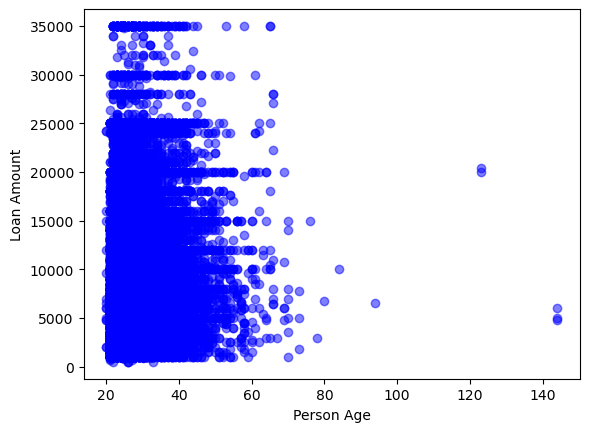

In [14]:
# Create the scatter plot for age and amount
plt.scatter(df['person_age'], df['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()


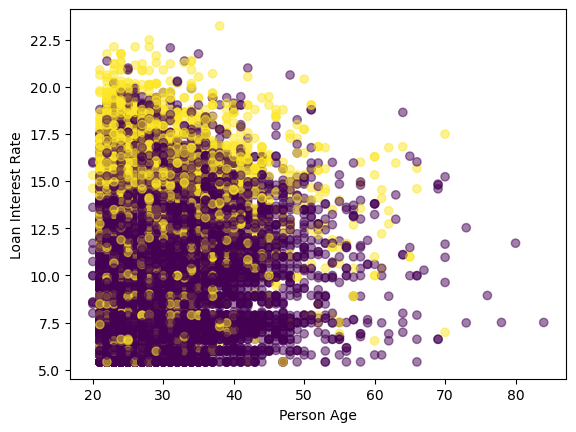

In [15]:
import matplotlib.pyplot as plt
# Use Pandas to drop the record from the data frame and create a new one
df_new= df.drop(df[df['person_age'] > 100].index)

# Create a scatter plot of age and interest rate
colors = ["blue", "red"]
plt.scatter(df_new['person_age'], df_new['loan_int_rate'],
            c=df_new['loan_status'],
            
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()


Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

C:\Users\hp\AppData\Local\Temp\ipykernel_13708\29714469.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)


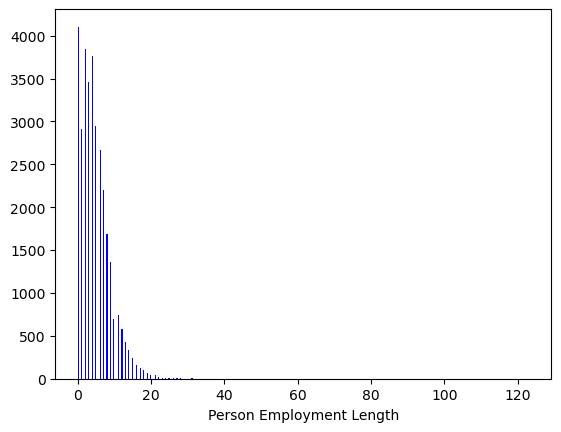

In [16]:
# Print a null value column array
print(df.columns[df.isnull().any()])

# Print the top five rows with nulls for employment length
print(df[df['person_emp_length'].isnull()].head())

# Impute the null values with the median value for all employment lengths
df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(df['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()


In [17]:
# Print the number of nulls
print(df['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = df[df['loan_int_rate'].isnull()].index

# Save the new data without missing data
df_clean = df.drop(indices)
df_clean


3116


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# phase 2

In [18]:
#2) TRAIN/TEST SPLIT 
#------------
target="loan_status"
x=df_clean.drop(columns=[target])
y=df_clean[target].astype(int)
x_train,x_test,y_train,y_test=train_test_split(
    x,y,test_size=0.25,random_state=42,stratify=y
)
cat_cols=[c for c in x_train.columns if x_train[c].dtype == "object"]
num_cols=[c for c in x_train.columns if x_train[c].dtype != "object"]
print("categorical:",cat_cols)
print("Numeric:",num_cols)

categorical: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Numeric: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [19]:
print("Categorical:",cat_cols)
print("Numeric:",num_cols)

Categorical: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Numeric: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [20]:
#preprocess:impute + one-hot
#-----------
numeric_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median"))
])
categorical_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])
preprocess=ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,num_cols),
        ("cat",categorical_transformer,cat_cols)
    ],
    remainder="drop"
)

In [21]:
#logistic regression model
#----------
logit=LogisticRegression(max_iter=2000,class_weight="balanced")
#balanced helps with ~ 22% defaults 
logit_model=Pipeline(steps=[
    ("preprocess",preprocess),
    ("model",logit)
])
logit_model.fit(x_train,y_train)


D:\anaconda1\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [22]:
#preds
y_proba_logit=logit_model.predict_proba(x_test)[:,1]
y_pred_logit=(y_proba_logit>=0.5).astype(int)



In [23]:
print("AUC:",roc_auc_score(y_test,y_proba_logit))


AUC: 0.8542654441500488


In [24]:
print(classification_report(y_test,y_pred_logit))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      5751
           1       0.51      0.78      0.62      1616

    accuracy                           0.79      7367
   macro avg       0.72      0.78      0.73      7367
weighted avg       0.84      0.79      0.80      7367



# phase 3

In [25]:
%pip install xgboost
import xgboost as xgb

Note: you may need to restart the kernel to use updated packages.


In [26]:
#--------
#3) XGBOOST PIPELINE (with SMOTE)
#-----------------
xgb_clf=xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)



In [27]:
#use imblearn pipeline so SMOTE happens AFTER preprocessing , inside CV safely
xgb_pipe=ImbPipeline(steps=[
    ("preprocess",preprocess),
    ("smote",SMOTE(random_state=42)),
    ("model",xgb_clf)
])

In [28]:
#cross-validation AUC
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
auc_scores=cross_val_score(xgb_pipe,x_train,y_train,cv=cv,
scoring="roc_auc")


D:\anaconda1\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\anaconda1\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [29]:
print("CV AUC scores:",auc_scores)
print("Mean CV AUC:",auc_scores.mean(),"std:",auc_scores.std())

CV AUC scores: [0.9454929  0.93989168 0.93190737 0.94127189 0.94232632]
Mean CV AUC: 0.9401780316048821 std: 0.004528695997410626


Test AUC: 0.941562358505021
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5751
           1       0.96      0.72      0.82      1616

    accuracy                           0.93      7367
   macro avg       0.94      0.85      0.89      7367
weighted avg       0.93      0.93      0.93      7367



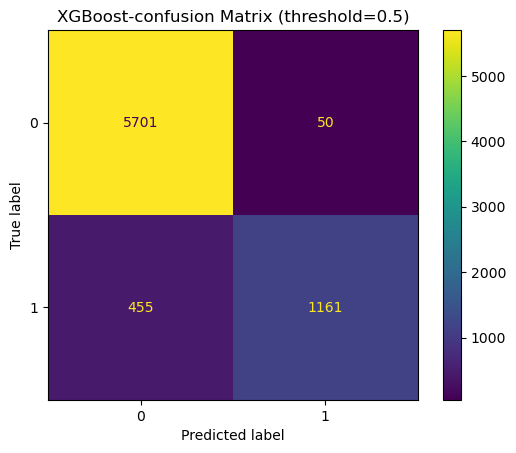

In [30]:
# Fit-Final
xgb_pipe.fit(x_train,y_train)
y_proba_xgb=xgb_pipe.predict_proba(x_test)[:,1]
y_pred_xgb=(y_proba_xgb>=0.5).astype(int)
print("Test AUC:",roc_auc_score(y_test,y_proba_xgb))
print(classification_report(y_test,y_pred_xgb))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb)
plt.title("XGBoost-confusion Matrix (threshold=0.5)")
plt.show()

In [31]:
#-------------
#3.3) Feature importance (permutation)
#--------------
perm= permutation_importance(
    xgb_pipe,x_test,y_test,
    scoring="roc_auc",
    n_repeats=5,
    random_state=42
)


In [32]:
# 1) Transform X_test exactly like the pipeline does
X_test_trans = xgb_pipe.named_steps["preprocess"].transform(x_test)

In [33]:
# 2) Get transformed feature names
feature_names = xgb_pipe.named_steps["preprocess"].get_feature_names_out()

In [34]:
# 3) Compute permutation importance on the transformed data using the trained model ONLY
perm = permutation_importance(
    xgb_pipe.named_steps["model"],
    X_test_trans,
    y_test,
    scoring="roc_auc",
    n_repeats=5,
    random_state=42
)

In [35]:
# 4) Now lengths will match
importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

top = importances.head(20)
top



num__loan_percent_income               0.095562
num__person_income                     0.082430
cat__person_home_ownership_OWN         0.028418
cat__loan_grade_A                      0.023986
cat__loan_grade_B                      0.014367
cat__person_home_ownership_RENT        0.012454
cat__loan_intent_VENTURE               0.012353
num__loan_int_rate                     0.011318
cat__loan_grade_D                      0.009776
cat__loan_intent_HOMEIMPROVEMENT       0.007425
cat__loan_grade_C                      0.007306
cat__person_home_ownership_MORTGAGE    0.004117
num__person_emp_length                 0.003213
cat__loan_intent_DEBTCONSOLIDATION     0.003198
num__person_age                        0.003106
cat__loan_intent_MEDICAL               0.002701
num__loan_amnt                         0.001828
cat__loan_intent_EDUCATION             0.001042
cat__cb_person_default_on_file_N       0.000952
cat__loan_grade_E                      0.000823
dtype: float64

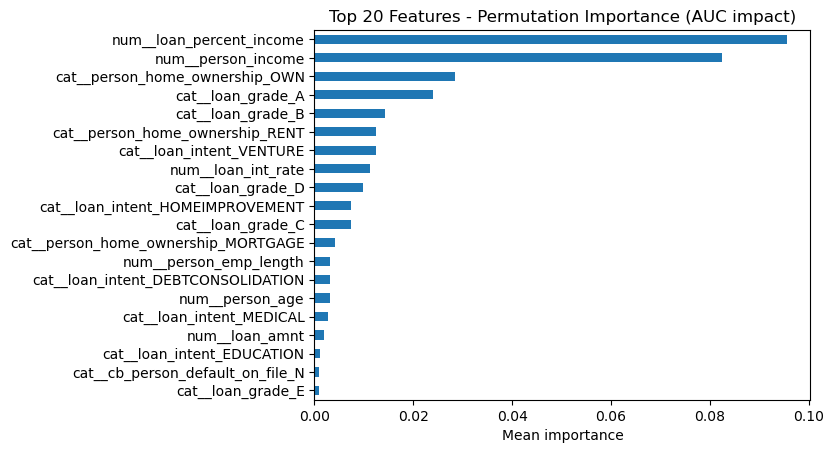

num__loan_percent_income               0.095562
num__person_income                     0.082430
cat__person_home_ownership_OWN         0.028418
cat__loan_grade_A                      0.023986
cat__loan_grade_B                      0.014367
cat__person_home_ownership_RENT        0.012454
cat__loan_intent_VENTURE               0.012353
num__loan_int_rate                     0.011318
cat__loan_grade_D                      0.009776
cat__loan_intent_HOMEIMPROVEMENT       0.007425
cat__loan_grade_C                      0.007306
cat__person_home_ownership_MORTGAGE    0.004117
num__person_emp_length                 0.003213
cat__loan_intent_DEBTCONSOLIDATION     0.003198
num__person_age                        0.003106
cat__loan_intent_MEDICAL               0.002701
num__loan_amnt                         0.001828
cat__loan_intent_EDUCATION             0.001042
cat__cb_person_default_on_file_N       0.000952
cat__loan_grade_E                      0.000823
dtype: float64

In [36]:
plt.figure()
top.sort_values().plot(kind="barh")
plt.title("Top 20 Features - Permutation Importance (AUC impact)")
plt.xlabel("Mean importance")
plt.show()

display(top)

# phase 4

In [37]:
#----------------
# ROC COMPARISON
#--------------
auc_logit=roc_auc_score(y_test,y_proba_logit)
auc_xgb=roc_auc_score(y_test,y_proba_xgb)
fpr_l, tpr_l,_ = roc_curve(y_test, y_proba_logit)
fpr_x, tpr_x,_ = roc_curve(y_test, y_proba_xgb)

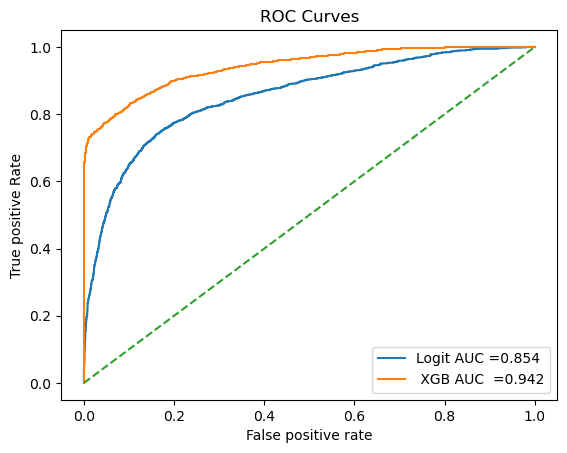

In [38]:
plt.figure()
plt.plot(fpr_l,tpr_l,label=f"Logit AUC ={auc_logit:.3f}")
plt.plot(fpr_x,tpr_x,label=f" XGB AUC  ={auc_xgb:.3f}")
plt.plot([0,1],[0,1],linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [39]:
print("AUC Logistic :",auc_logit)
print("AUC XGBoost :",auc_xgb)

AUC Logistic : 0.8542654441500488
AUC XGBoost : 0.941562358505021


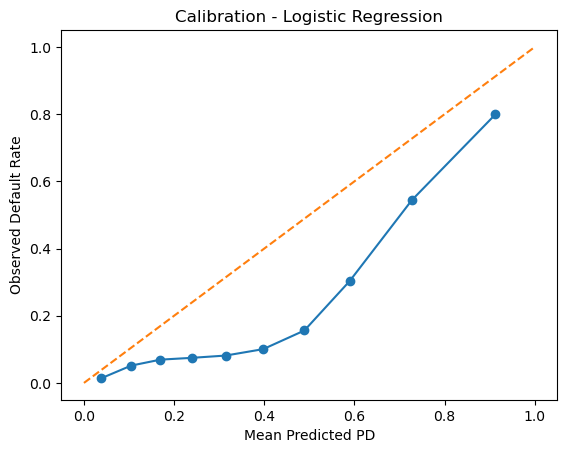

Brier score: 0.15194348369115201


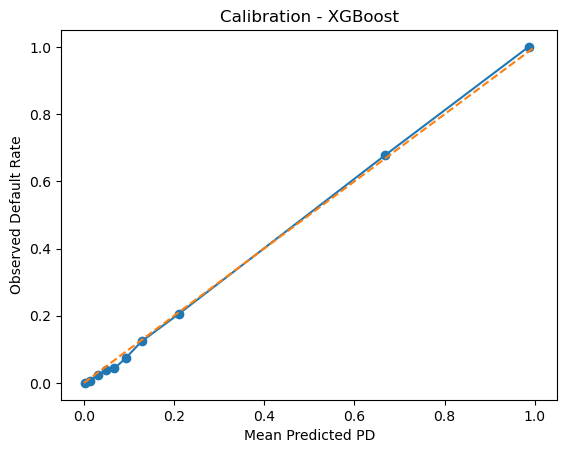

Brier score: 0.057238768942073415


In [40]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def plot_calibration(y_true, y_proba, title, n_bins=10):
    # calibration_curve returns: fraction_of_positives, mean_predicted_value
    frac_pos, mean_pred = calibration_curve(
        y_true, y_proba, n_bins=n_bins, strategy="quantile"
    )

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean Predicted PD")
    plt.ylabel("Observed Default Rate")
    plt.title(title)
    plt.show()

    print("Brier score:", brier_score_loss(y_true, y_proba))

# Call it:
plot_calibration(y_test, y_proba_logit, "Calibration - Logistic Regression")
plot_calibration(y_test, y_proba_xgb, "Calibration - XGBoost")

In [41]:
# =========================
# Calibrate XGB (Platt scaling)
# =========================
# We calibrate using CV on training data
cal_xgb = CalibratedClassifierCV(xgb_pipe, method="sigmoid", cv=5)
cal_xgb.fit(x_train, y_train)
y_proba_xgb_cal = cal_xgb.predict_proba(x_test)[:, 1]


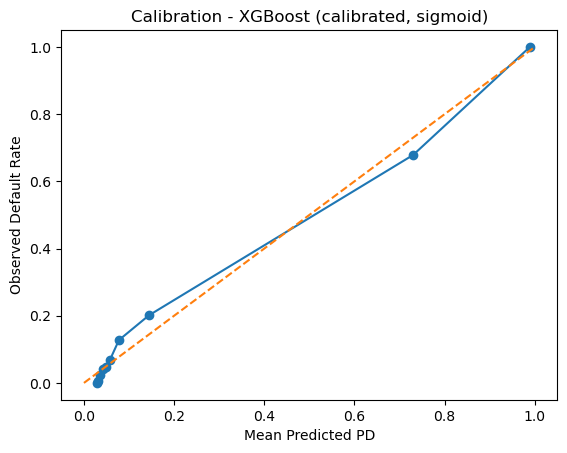

Brier score: 0.05786168026499087


In [42]:

plot_calibration(y_test, y_proba_xgb_cal, "Calibration - XGBoost (calibrated, sigmoid)")


In [43]:
print("AUC XGB calibrated:", roc_auc_score(y_test, y_proba_xgb_cal))

AUC XGB calibrated: 0.940583514532987


In [44]:
# =========================
# 4.3) Strategy Table
# =========================
results = x_test.copy()
results["y_true"] = y_test.values



In [45]:
# Choose which PD to use (logit vs xgb vs calibrated xgb)
results["pd_logit"] = y_proba_logit
results["pd_xgb"] = y_proba_xgb
results["pd_xgb_cal"] = y_proba_xgb_cal if "y_proba_xgb_cal" in globals() else y_proba_xgb



In [46]:

# EAD from dataset (loan amount)
results["EAD"] = results["loan_amnt"].astype(float)

# Choose an LGD assumption (portfolio project assumption)
LGD = 0.45
results["LGD"] = LGD

In [47]:
def make_strategy_table(df_scored, pd_col, steps=20):
    tmp = df_scored.copy().sort_values(pd_col)  # lowest PD first (best applicants)
    n = len(tmp)

    rows = []
    for a in np.linspace(0.05, 1.0, steps):
        k = int(np.floor(a * n))
        accepted = tmp.iloc[:k].copy()

        # acceptance threshold = max PD accepted
        thr = accepted[pd_col].max() if k > 0 else np.nan

        bad_rate = accepted["y_true"].mean() if k > 0 else np.nan
        exp_loss = (accepted[pd_col] * accepted["LGD"] * accepted["EAD"]).sum() if k > 0 else 0.0

        # A simple "value proxy": total EAD - expected loss
        # (real banks would use interest margin, costs, capital, etc.)
        total_ead = accepted["EAD"].sum() if k > 0 else 0.0
        value_proxy = total_ead - exp_loss

        rows.append({
            "acceptance_rate": a,
            "accepted_n": k,
            "pd_threshold": thr,
            "observed_bad_rate": bad_rate,
            "total_EAD": total_ead,
            "expected_loss": exp_loss,
            "value_proxy_(EAD-EL)": value_proxy
        })

    return pd.DataFrame(rows)

In [48]:
st_logit = make_strategy_table(results, "pd_logit", steps=20)
st_xgb = make_strategy_table(results, "pd_xgb", steps=20)
st_xgb_cal = make_strategy_table(results, "pd_xgb_cal", steps=20)

display(st_logit.head())
display(st_xgb_cal.head())

,acceptance_rate,accepted_n,pd_threshold,observed_bad_rate,total_EAD,expected_loss,value_proxy_(EAD-EL)
0,0.05,368,0.039811,0.010870,3717250.0,29080.625449,3.688169e+06
1,0.10,736,0.071518,0.013587,6679100.0,103981.499728,6.575119e+06
2,0.15,1105,0.105004,0.022624,9655850.0,223832.576768,9.432017e+06
3,0.20,1473,0.136611,0.031908,12716500.0,390097.470017,1.232640e+07
4,0.25,1841,0.169710,0.039109,15955950.0,613965.995938,1.534198e+07


,acceptance_rate,accepted_n,pd_threshold,observed_bad_rate,total_EAD,expected_loss,value_proxy_(EAD-EL)
0,0.05,368,0.028343,0.000000,3082800.0,39050.646290,3.043749e+06
1,0.10,736,0.029215,0.000000,6867225.0,87970.153054,6.779255e+06
2,0.15,1105,0.030777,0.002715,10156700.0,132244.079974,1.002446e+07
3,0.20,1473,0.033202,0.002716,13672900.0,182705.218699,1.349019e+07
4,0.25,1841,0.035805,0.005432,17234225.0,238006.603326,1.699622e+07


In [49]:
# =========================
# 4.4) Acceptance vs Bad Rate / Value
# =========================
def plot_strategy(st, title_prefix):
    plt.figure()
    plt.plot(st["acceptance_rate"], st["observed_bad_rate"], marker="o")
    plt.xlabel("Acceptance Rate")
    plt.ylabel("Bad Rate (Observed Default)")
    plt.title(f"{title_prefix}: Acceptance Rate vs Bad Rate")
    plt.show()

    plt.figure()
    plt.plot(st["acceptance_rate"], st["value_proxy_(EAD-EL)"], marker="o")
    plt.xlabel("Acceptance Rate")
    plt.ylabel("Value Proxy (EAD - EL)")
    plt.title(f"{title_prefix}: Acceptance Rate vs Value Proxy")
    plt.show()




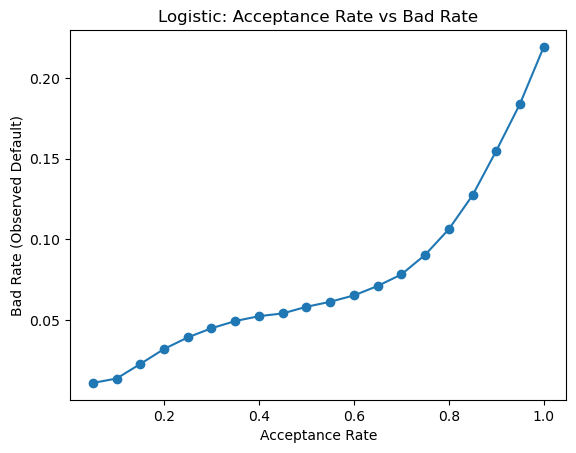

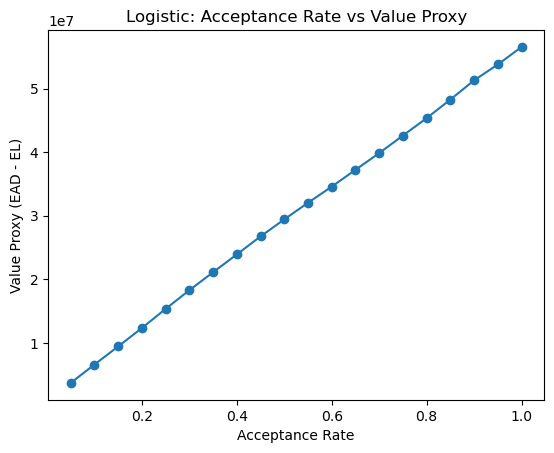

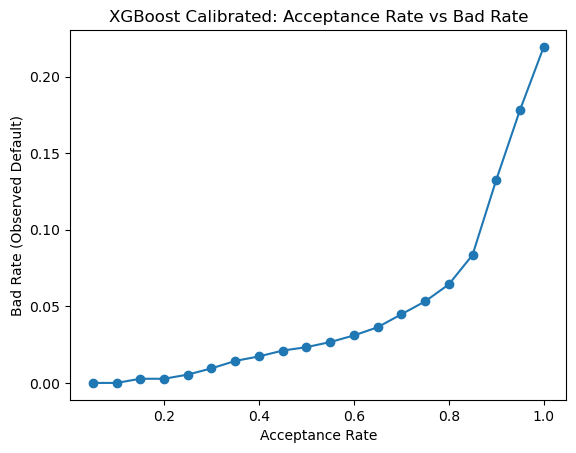

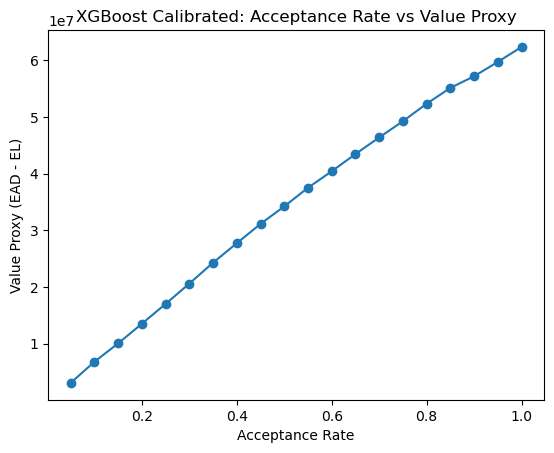

In [50]:
plot_strategy(st_logit, "Logistic")
plot_strategy(st_xgb_cal, "XGBoost Calibrated")

In [54]:
new_customer = pd.DataFrame({
    'person_age': [32],
    'person_income': [55000],
    'person_emp_length': [6],
    'person_home_ownership': ['RENT'],
    'loan_amnt': [12000],
    'loan_intent': ['PERSONAL'],
    'loan_grade': ['B'],
    'loan_int_rate': [11.5],
    'loan_percent_income': [0.22],

    # ✅ ADD MISSING CREDIT BUREAU FEATURES
    'cb_person_cred_hist_length': [8],   # years of credit history
    'cb_person_default_on_file': ['N']   # 'Y' or 'N'
})


In [56]:
pd_new = xgb_pipe.predict_proba(new_customer)[0, 1]
pd_new


np.float32(0.090483926)

In [59]:
float(pd_new)


0.09048392623662949

In [57]:
CUTOFF_PD = 0.10  # fixed, justified cutoff

if pd_new <= CUTOFF_PD:
    decision = "APPROVE LOAN"
else:
    decision = "REJECT LOAN"

decision


'APPROVE LOAN'

In [64]:
#EL = pd_new * LGD * EAD(loan_amount)
EL = 0.0905 * 0.45 * 12000
EL


488.7